# Libraries

In [ ]:
import kagglehub
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from IPython.display import Image
import tensorflow as tf
import torch
# from torchviz import make_dot
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from skimage.transform import resize
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from collections import defaultdict
from tqdm import tqdm
import random

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hearfool/vggface2")

print("Path to dataset files:", path)

In [ ]:
train_path = '/root/.cache/kagglehub/datasets/hearfool/vggface2/train'
val_path = '/root/.cache/kagglehub/datasets/hearfool/vggface2/val'

In [ ]:
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

100%|██████████| 112M/112M [00:06<00:00, 19.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_dir = '/root/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4/lfw-deepfunneled/lfw-deepfunneled'

# Preview, Preprocessing and Data Augmentation

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.jpg') or img_path.endswith('.png'):
            img = Image.open(img_path)
            images.append(img)
    return images

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, triplets, transform=None):
        self.triplets = triplets
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        return anchor, positive, negative

def load_images_from_folder(folder):
    return [Image.open(os.path.join(folder, f)) for f in os.listdir(folder) if f.endswith(('png', 'jpg', 'jpeg'))]

def triplet_generator(people_folders, base_path, batch_size=1000):
    triplets = []
    while True:
        for _ in range(batch_size):
            anchor_person = random.choice(people_folders)
            anchor_folder = os.path.join(base_path, anchor_person)
            anchor_images = load_images_from_folder(anchor_folder)

            if len(anchor_images) < 2:
                continue

            anchor, positive = random.sample(anchor_images, 2)

            negative_person = random.choice(people_folders)
            while negative_person == anchor_person:
                negative_person = random.choice(people_folders)

            negative_folder = os.path.join(base_path, negative_person)
            negative_images = load_images_from_folder(negative_folder)
            if not negative_images:
                continue

            negative = random.choice(negative_images)

            triplets.append((anchor, positive, negative))

        yield triplets
        triplets.clear()
        torch.cuda.empty_cache()

def load_data_in_batches(deep_funneled_path, transform, batch_size=1000):
    triplet_gen = triplet_generator(deep_funneled_path, batch_size=batch_size)
    for triplets in triplet_gen:
        dataset = TripletDataset(triplets, transform=transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        yield dataloader

In [ ]:
deep_funneled_path = images_dir
people_folders = [f for f in os.listdir(deep_funneled_path) if os.path.isdir(os.path.join(deep_funneled_path, f))]
train_people, val_people = train_test_split(people_folders, test_size=0.1, random_state=42)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5)
    transforms.RandomRotation(3),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
from PIL import Image

train_triplet_gen = triplet_generator(train_people, deep_funneled_path, batch_size=1000)
val_triplet_gen = triplet_generator(val_people, deep_funneled_path, batch_size=1000)

total_train_triplets = 27000
total_val_triplets = 3000

train_triplets, val_triplets = [], []

while len(train_triplets) < total_train_triplets:
    batch_triplets = next(train_triplet_gen)
    train_triplets.extend(batch_triplets)
    print(f"Generated {len(train_triplets)} train triplets so far...")

while len(val_triplets) < total_val_triplets:
    batch_triplets = next(val_triplet_gen)
    val_triplets.extend(batch_triplets)
    print(f"Generated {len(val_triplets)} validation triplets so far...")

train_triplets = train_triplets[:total_train_triplets]
val_triplets = val_triplets[:total_val_triplets]

print(f"Total Train Triplets: {len(train_triplets)}")
print(f"Total Validation Triplets: {len(val_triplets)}")

Generated 292 train triplets so far...
Generated 568 train triplets so far...
Generated 859 train triplets so far...
Generated 1154 train triplets so far...
Generated 1459 train triplets so far...
Generated 1756 train triplets so far...
Generated 2070 train triplets so far...
Generated 2359 train triplets so far...
Generated 2664 train triplets so far...
Generated 2919 train triplets so far...
Generated 3218 train triplets so far...
Generated 3521 train triplets so far...
Generated 3842 train triplets so far...
Generated 4122 train triplets so far...
Generated 4403 train triplets so far...
Generated 4682 train triplets so far...
Generated 4964 train triplets so far...
Generated 5250 train triplets so far...
Generated 5559 train triplets so far...
Generated 5851 train triplets so far...
Generated 6147 train triplets so far...
Generated 6455 train triplets so far...
Generated 6740 train triplets so far...
Generated 7039 train triplets so far...
Generated 7329 train triplets so far...
Gen

In [ ]:
train_dataset = TripletDataset(train_triplets, transform=transform)
test_dataset = TripletDataset(val_triplets, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 844
Test batches: 94


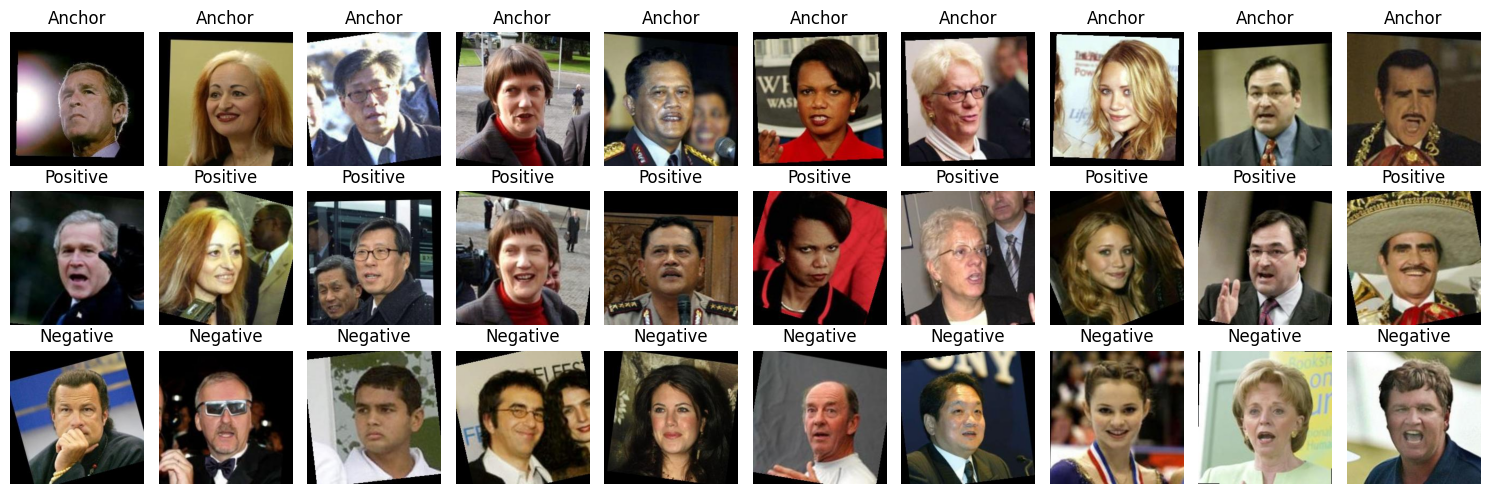

In [ ]:
def visualize_triplets(triplets, num_triplets=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_triplets):
        anchor, positive, negative = triplets[i]

        plt.subplot(3, num_triplets, i + 1)
        plt.imshow(anchor)
        plt.title("Anchor")
        plt.axis("off")

        plt.subplot(3, num_triplets, i + 1 + num_triplets)
        plt.imshow(positive)
        plt.title("Positive")
        plt.axis("off")

        plt.subplot(3, num_triplets, i + 1 + 2 * num_triplets)
        plt.imshow(negative)
        plt.title("Negative")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
visualize_triplets(train_triplets, num_triplets=10)

# Define Teacher Model

In [ ]:
class TeacherSiameseNetwork(nn.Module):
    def __init__(self, embedding_size=128):
        super(TeacherSiameseNetwork, self).__init__()
        resnet = models.resnet101(pretrained=True)
        feature_dim = 2048

        for param in list(resnet.parameters())[:-10]:
            param.requires_grad = False
        for param in list(resnet.parameters())[-10:]:
            param.requires_grad = True

        # Remove classification layers
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, embedding_size),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(inplace=True)
        )

    def forward_one(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2


teacher_model = TeacherSiameseNetwork(embedding_size=128)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Define Student Model

In [ ]:
class StudentSiameseNetwork(nn.Module):
    def __init__(self, embedding_size=128):
        super(StudentSiameseNetwork, self).__init__()
        efficientnet = models.efficientnet_b0(pretrained=True)

        for param in efficientnet.parameters():
            param.requires_grad = False
        for param in list(efficientnet.features[-1].parameters()):
            param.requires_grad = True
        for param in list(efficientnet.features[-2].parameters()):
            param.requires_grad = True

        self.backbone = efficientnet.features

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, embedding_size),
            nn.BatchNorm1d(embedding_size),
            nn.ReLU(inplace=True)
        )

    def forward_one(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2
student_model = StudentSiameseNetwork(embedding_size=128)

In [ ]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 592.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 392.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 986.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nv

# Define Loss

In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=3.0, margin=1.0):
        super(DistillationLoss, self).__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.margin = margin
        self.triplet_loss = nn.TripletMarginLoss(margin=margin)

    def forward(self, anchor_s, positive_s, negative_s, anchor_t, positive_t, negative_t):
        triplet_loss = self.triplet_loss(anchor_s, positive_s, negative_s)

        # Distillation Loss (L2 between student and teacher embeddings)
        distill_loss = (F.mse_loss(anchor_s, anchor_t) +
                        F.mse_loss(positive_s, positive_t) +
                        F.mse_loss(negative_s, negative_t)) / 3

        # Total Loss
        return self.alpha * triplet_loss + (1 - self.alpha) * distill_loss

# Teacher Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
for param in teacher_model.parameters():
    param.data = param.data.to(device)

In [ ]:
teacher_model = teacher_model.to(device)

In [ ]:
teacher_optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.0003)
teacher_loss_fn = nn.TripletMarginLoss(margin=1)

In [ ]:
num_epochs = 15
train_losses = []
train_accuracies = []
val_accuracies = []

teacher_model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    TP_train = FP_train = TN_train = FN_train = 0

    # Training Loop
    for anchor, positive, negative in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        anchor_t = teacher_model.forward_one(anchor)
        positive_t = teacher_model.forward_one(positive)
        negative_t = teacher_model.forward_one(negative)

        loss = nn.TripletMarginLoss()(anchor_t, positive_t, negative_t)

        teacher_optimizer.zero_grad()
        loss.backward()
        teacher_optimizer.step()

        running_loss += loss.item()

        # Compute training accuracy
        pos_similarity = F.cosine_similarity(anchor_t, positive_t)
        neg_similarity = F.cosine_similarity(anchor_t, negative_t)

        TP_train += torch.sum(pos_similarity > 0.5).item()
        FN_train += torch.sum(pos_similarity <= 0.5).item()
        TN_train += torch.sum(neg_similarity < 0.5).item()
        FP_train += torch.sum(neg_similarity >= 0.5).item()

    train_accuracy = ((TP_train + TN_train) / (TP_train + FP_train + TN_train + FN_train)) * 100
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation Loop
    teacher_model.eval()
    TP_val = FP_val = TN_val = FN_val = 0
    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_t = teacher_model.forward_one(anchor)
            positive_t = teacher_model.forward_one(positive)
            negative_t = teacher_model.forward_one(negative)

            pos_similarity = F.cosine_similarity(anchor_t, positive_t)
            neg_similarity = F.cosine_similarity(anchor_t, negative_t)

            TP_val += torch.sum(pos_similarity > 0.5).item()
            FN_val += torch.sum(pos_similarity <= 0.5).item()
            TN_val += torch.sum(neg_similarity < 0.5).item()
            FP_val += torch.sum(neg_similarity >= 0.5).item()

    val_accuracy = ((TP_val + TN_val) / (TP_val + FP_val + TN_val + FN_val)) * 100
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

Epoch 1/15: 100%|██████████| 844/844 [06:40<00:00,  2.11it/s]


Epoch [1/15], Loss: 0.6093, Train Acc: 70.91%, Val Acc: 74.62%


Epoch 2/15: 100%|██████████| 844/844 [05:55<00:00,  2.37it/s]


Epoch [2/15], Loss: 0.4454, Train Acc: 77.55%, Val Acc: 75.27%


Epoch 3/15: 100%|██████████| 844/844 [05:54<00:00,  2.38it/s]


Epoch [3/15], Loss: 0.4036, Train Acc: 79.59%, Val Acc: 77.17%


Epoch 4/15: 100%|██████████| 844/844 [05:54<00:00,  2.38it/s]


Epoch [4/15], Loss: 0.3750, Train Acc: 80.93%, Val Acc: 77.32%


Epoch 5/15: 100%|██████████| 844/844 [05:54<00:00,  2.38it/s]


Epoch [5/15], Loss: 0.3520, Train Acc: 82.19%, Val Acc: 77.52%


Epoch 6/15: 100%|██████████| 844/844 [05:55<00:00,  2.37it/s]


Epoch [6/15], Loss: 0.3305, Train Acc: 83.37%, Val Acc: 77.82%


Epoch 7/15: 100%|██████████| 844/844 [05:54<00:00,  2.38it/s]


Epoch [7/15], Loss: 0.3108, Train Acc: 84.14%, Val Acc: 78.87%


Epoch 8/15: 100%|██████████| 844/844 [05:53<00:00,  2.39it/s]


Epoch [8/15], Loss: 0.2986, Train Acc: 84.76%, Val Acc: 78.73%


Epoch 9/15: 100%|██████████| 844/844 [05:54<00:00,  2.38it/s]


Epoch [9/15], Loss: 0.2885, Train Acc: 85.32%, Val Acc: 79.27%


Epoch 10/15: 100%|██████████| 844/844 [05:55<00:00,  2.38it/s]


Epoch [10/15], Loss: 0.2733, Train Acc: 86.09%, Val Acc: 78.27%


Epoch 11/15: 100%|██████████| 844/844 [05:55<00:00,  2.37it/s]


Epoch [11/15], Loss: 0.2612, Train Acc: 86.69%, Val Acc: 78.80%


Epoch 12/15: 100%|██████████| 844/844 [05:56<00:00,  2.37it/s]


Epoch [12/15], Loss: 0.2544, Train Acc: 86.82%, Val Acc: 78.90%


Epoch 13/15: 100%|██████████| 844/844 [05:55<00:00,  2.37it/s]


Epoch [13/15], Loss: 0.2439, Train Acc: 87.33%, Val Acc: 79.18%


Epoch 14/15: 100%|██████████| 844/844 [05:55<00:00,  2.37it/s]


Epoch [14/15], Loss: 0.2350, Train Acc: 87.66%, Val Acc: 78.33%


Epoch 15/15: 100%|██████████| 844/844 [05:56<00:00,  2.37it/s]


Epoch [15/15], Loss: 0.2304, Train Acc: 87.89%, Val Acc: 79.65%


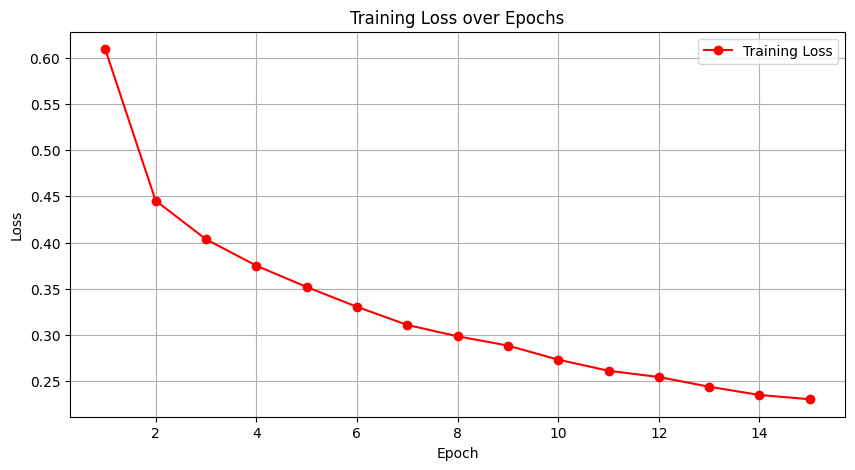

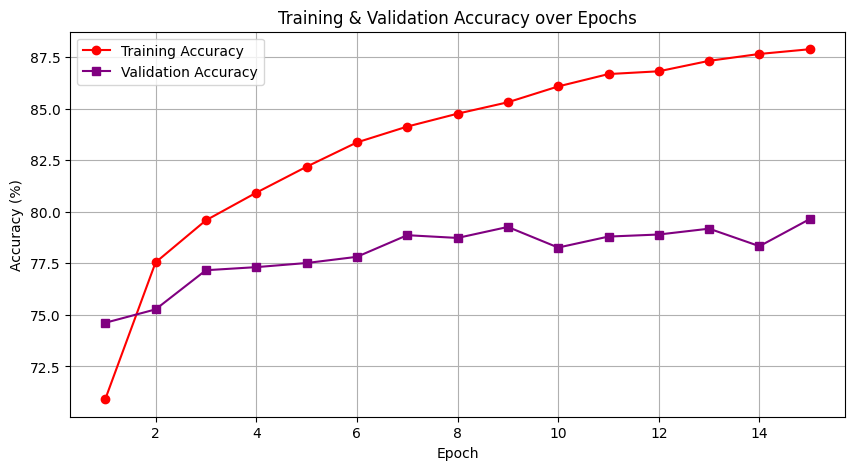

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", marker='o', color='red')
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy", marker='s', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
save_path = '/content/drive/My Drive/Teacher_facial_recognition_model.pth'

torch.save(teacher_model.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: /content/drive/My Drive/Teacher_facial_recognition_model.pth


# Student Training

In [ ]:
teacher_model = TeacherSiameseNetwork(embedding_size=128).to(device)
teacher_model.load_state_dict(torch.load("/content/drive/My Drive/Teacher_facial_recognition_model.pth"))
teacher_model.eval()

<ipython-input-40-1df2b553fa6f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("/content/drive/My Drive/Teacher_facial_recognition

TeacherSiameseNetwork(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [ ]:
distill_loss_fn = DistillationLoss(alpha=0.7, temperature=3.0)
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0001)

In [ ]:
student_model = student_model.to(device)

In [ ]:
student_model.train()
num_epochs = 20
student_train_losses = []
student_train_accuracies = []
student_val_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    TP_train = FP_train = TN_train = FN_train = 0

    for anchor, positive, negative in tqdm(train_loader, desc=f"Student Model - Training Epoch {epoch+1}/{num_epochs}"):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        with torch.no_grad():
            anchor_t = teacher_model.forward_one(anchor)
            positive_t = teacher_model.forward_one(positive)
            negative_t = teacher_model.forward_one(negative)

        anchor_s = student_model.forward_one(anchor)
        positive_s = student_model.forward_one(positive)
        negative_s = student_model.forward_one(negative)

        loss = DistillationLoss()(anchor_s, positive_s, negative_s, anchor_t, positive_t, negative_t)

        student_optimizer.zero_grad()
        loss.backward()
        student_optimizer.step()
        running_loss += loss.item()

        # Compute training accuracy
        pos_similarity = F.cosine_similarity(anchor_s, positive_s)
        neg_similarity = F.cosine_similarity(anchor_s, negative_s)

        TP_train += torch.sum(pos_similarity > 0.5).item()
        FN_train += torch.sum(pos_similarity <= 0.5).item()
        TN_train += torch.sum(neg_similarity < 0.5).item()
        FP_train += torch.sum(neg_similarity >= 0.5).item()

    train_accuracy = ((TP_train + TN_train) / (TP_train + FP_train + TN_train + FN_train)) * 100
    student_train_losses.append(running_loss / len(train_loader))
    student_train_accuracies.append(train_accuracy)

    student_model.eval()
    TP_val = FP_val = TN_val = FN_val = 0
    with torch.no_grad():
        for anchor, positive, negative in tqdm(test_loader, desc=f"Student Model - Validation Epoch {epoch+1}/{num_epochs}"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_s = student_model.forward_one(anchor)
            positive_s = student_model.forward_one(positive)
            negative_s = student_model.forward_one(negative)

            pos_similarity = F.cosine_similarity(anchor_s, positive_s)
            neg_similarity = F.cosine_similarity(anchor_s, negative_s)

            TP_val += torch.sum(pos_similarity > 0.5).item()
            FN_val += torch.sum(pos_similarity <= 0.5).item()
            TN_val += torch.sum(neg_similarity < 0.5).item()
            FP_val += torch.sum(neg_similarity >= 0.5).item()

    val_accuracy = ((TP_val + TN_val) / (TP_val + FP_val + TN_val + FN_val)) * 100
    student_val_accuracies.append(val_accuracy)

    print(f"Student Model - Epoch [{epoch+1}/{num_epochs}], Loss: {student_train_losses[-1]:.4f}, Train Acc: {student_train_accuracies[-1]:.2f}%, Val Acc: {student_val_accuracies[-1]:.2f}%")

Student Model - Validation Epoch 1/20: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Student Model - Epoch [1/20], Loss: 0.3730, Train Acc: 66.81%, Val Acc: 73.43%


Student Model - Validation Epoch 2/20: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Student Model - Epoch [2/20], Loss: 0.2178, Train Acc: 79.25%, Val Acc: 76.62%


Student Model - Validation Epoch 3/20: 100%|██████████| 94/94 [00:36<00:00,  2.60it/s]


Student Model - Epoch [3/20], Loss: 0.1778, Train Acc: 83.35%, Val Acc: 79.10%


Student Model - Validation Epoch 4/20: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Student Model - Epoch [4/20], Loss: 0.1535, Train Acc: 85.55%, Val Acc: 79.48%


Student Model - Validation Epoch 5/20: 100%|██████████| 94/94 [00:36<00:00,  2.59it/s]


Student Model - Epoch [5/20], Loss: 0.1335, Train Acc: 87.55%, Val Acc: 79.63%


Student Model - Validation Epoch 6/20: 100%|██████████| 94/94 [00:36<00:00,  2.60it/s]


Student Model - Epoch [6/20], Loss: 0.1196, Train Acc: 88.92%, Val Acc: 80.10%


Student Model - Validation Epoch 7/20: 100%|██████████| 94/94 [00:36<00:00,  2.57it/s]


Student Model - Epoch [7/20], Loss: 0.1085, Train Acc: 89.91%, Val Acc: 79.35%


Student Model - Validation Epoch 8/20: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Student Model - Epoch [8/20], Loss: 0.1000, Train Acc: 90.74%, Val Acc: 79.78%


Student Model - Validation Epoch 9/20: 100%|██████████| 94/94 [00:37<00:00,  2.53it/s]


Student Model - Epoch [9/20], Loss: 0.0921, Train Acc: 91.41%, Val Acc: 78.82%


Student Model - Validation Epoch 10/20: 100%|██████████| 94/94 [00:37<00:00,  2.54it/s]


Student Model - Epoch [10/20], Loss: 0.0865, Train Acc: 91.91%, Val Acc: 79.55%


Student Model - Validation Epoch 11/20: 100%|██████████| 94/94 [00:36<00:00,  2.56it/s]


Student Model - Epoch [11/20], Loss: 0.0806, Train Acc: 92.52%, Val Acc: 78.63%


Student Model - Validation Epoch 12/20: 100%|██████████| 94/94 [00:36<00:00,  2.58it/s]


Student Model - Epoch [12/20], Loss: 0.0760, Train Acc: 92.90%, Val Acc: 79.02%


Student Model - Validation Epoch 13/20: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Student Model - Epoch [13/20], Loss: 0.0711, Train Acc: 93.33%, Val Acc: 78.48%


Student Model - Validation Epoch 14/20: 100%|██████████| 94/94 [00:36<00:00,  2.55it/s]


Student Model - Epoch [14/20], Loss: 0.0670, Train Acc: 93.84%, Val Acc: 78.18%


Student Model - Training Epoch 15/20:  25%|██▍       | 207/844 [01:32<04:44,  2.24it/s]


KeyboardInterrupt: 

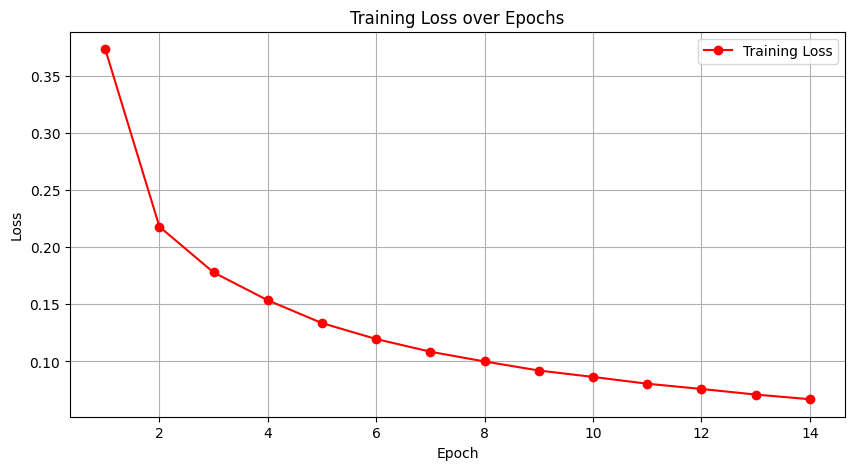

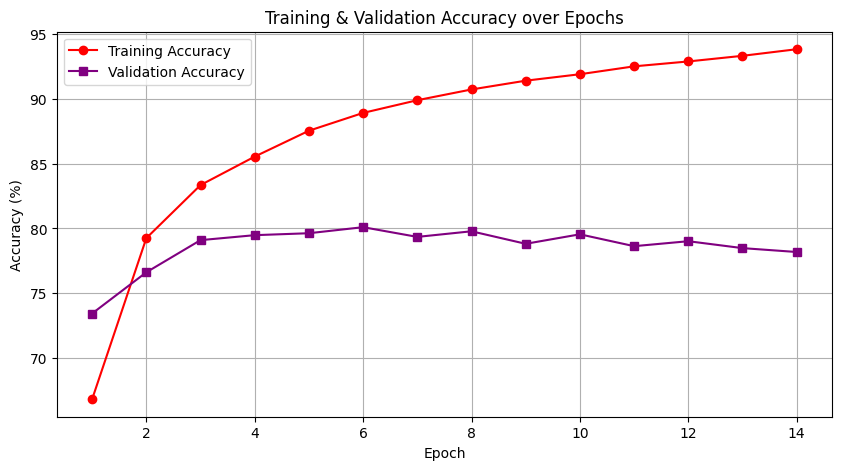

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 14 + 1), student_train_losses, label="Training Loss", marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, 14 + 1), student_train_accuracies, label="Training Accuracy", marker='o', color='red')
plt.plot(range(1, 14 + 1), student_val_accuracies, label="Validation Accuracy", marker='s', color='purple')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:
save_path = '/content/drive/My Drive/Student_facial_recognition_model.pth'

torch.save(student_model.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: /content/drive/My Drive/Student_facial_recognition_model.pth


# Evaluation

Evaluating Student Model: 100%|██████████| 94/94 [00:36<00:00,  2.54it/s]

Student Model Evaluation:
Accuracy: 77.82%
Precision: 0.8484
Recall: 0.6773
F1 Score: 0.7533
Macro F1 Score: 0.7759
Micro F1 Score: 0.7782


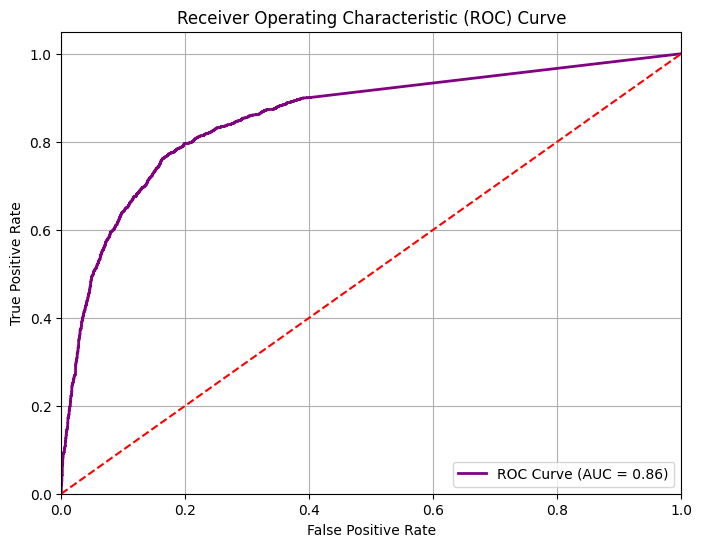

In [ ]:
student_model.eval()

TP = FP = TN = FN = 0
all_labels = []
all_scores = []

with torch.no_grad():
    for anchor, positive, negative in tqdm(test_loader, desc="Evaluating Student Model"):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        anchor_s = student_model.forward_one(anchor)
        positive_s = student_model.forward_one(positive)
        negative_s = student_model.forward_one(negative)

        pos_similarity = F.cosine_similarity(anchor_s, positive_s).cpu().numpy()
        neg_similarity = F.cosine_similarity(anchor_s, negative_s).cpu().numpy()


        labels = [1] * len(pos_similarity) + [0] * len(neg_similarity)
        scores = list(pos_similarity) + list(neg_similarity)

        all_labels.extend(labels)
        all_scores.extend(scores)

        TP += (pos_similarity > 0.5).sum()
        FN += (pos_similarity <= 0.5).sum()
        TN += (neg_similarity < 0.5).sum()
        FP += (neg_similarity >= 0.5).sum()

predictions = [1 if s > 0.5 else 0 for s in all_scores]

accuracy = ((TP + TN) / (TP + FP + TN + FN)) * 100
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)
macro_f1 = f1_score(all_labels, predictions, average='macro')
micro_f1 = f1_score(all_labels, predictions, average='micro')

# Display Metrics
print(f"Student Model Evaluation:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()